# Optimize customer support workflows with generative AI

Workflow optimisation for customer support is an important part of a Support team in any organization. While every customer request and ticket is important, some are more important than others. Automated prioritization of tickers/requests has been solved through various approaches including predictive modeling. Automated request resolution is the next barrier to conquer. 

Pareto principle is applicable to customer support requests, in the sense that majority of the requests will be <a href='https://www.indeed.com/career-advice/finding-a-job/what-is-level-1-2-3-support'>Level 1</a> requests for information. These requests aren't the best use of a customer support personnel's time and need to be automated. Generative AI provides a compelling answer to automate said requests allowing support staff to focus their attention towards more pressing and high visibility requests. 

Generative AI agents can use historical conversations and support documentation to automate responses to customer requests. While it is tempting to push all requests through automation, understand that generative AI is not free. Generative AI costs include cost per request, total tokens, compute etc. Predictive ML models can optimize this by classifying which requests can be sent to gen AI models and which can be routed to human agents, thereby optimizing workflows.

## Scenario

To illustrate an example, this acclerator optimizes a <a href='https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter'>customer support on Twitter dataset</a>. This dataset collates interactions between organizations and their user base on <a href='https://twitter.com/home?lang=en'>X</a>(formerly Twitter). You will build a generative solution that uses a predictive model to route the user tweet to a human agent or an LLM. The LLM will use historical support conversations to provide troubleshooting advice and next steps to the user.

## Setup

1. Enable the following **feature flags** on your account:
    - Enable Notebooks Filesystem Management
    - Enable Proxy models
    - Enable Public Network Access for all Custom Models 
	- Enable the Injection of Runtime Parameters for Custom Models
    - Enable Monitoring Support for Generative Models
    - Enable Custom Inference Models
2. Enable the notebook filesystem for this notebook in the notebook sidebar/
3. Add the notebook environment variables `OPENAI_API_KEY`, `OPENAI_ORGANIZATION`,
   and `OPENAI_API_BASE`. Set the values with your Azure OpenAI credentials.
4. Set the notebook session timeout to 180 minutes.
5. Restart the notebook container using at least a medium (16GB ram) instance.
6. Upload your documents archive to the notebook.

In [ ]:
try:
    import os

    assert "OPENAI_API_KEY" in os.environ
    assert "OPENAI_ORGANIZATION" in os.environ
    assert "OPENAI_API_BASE" in os.environ
except Exception as e:
    raise RuntimeError("Please follow the setup steps before running the notebook.") from e

### Install libraries
This accelerator uses <a href='https://python.langchain.com/docs/get_started/introduction.html'>Langchain</a> for developing the agent and <a href='https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/'>FAISS</a> and <a href='https://www.sbert.net/'>Sentence Transformers</a> for the <a href='https://arxiv.org/abs/2005.11401'>RAG</a> system. The LLM is an OpenAI model hosted on Azure. DataRobot provides the freedom for you to use your preferred components in the stack. This accelerator also uses <a href='https://networkx.org/documentation/stable/tutorial.html'>Networkx</a> for data engineering purposes. 

In [1]:
!pip install "langchain==0.0.244" \
             "faiss-cpu==1.7.4" \
             "sentence-transformers==2.2.2" \
             "unstructured==0.8.4" \
             "openai==0.27.8" \
             "datarobotx==0.1.14"

In [2]:
!pip install datarobotx[llm] json2html networkx transformers

### Document corpus

The "Customer support on Twitter" dataset consists of the tweets between users and the support personnel for the X social media platform. Each row in the dataset represents a dialog in the conversation between a user and the support personnel from the organization. While it is easy to load each tweet individually into the knowledge base, it will not provide sufficient context to the LLM during prompting. Therefore, add an additional step to combine tweets from a conversation into a single document. This allows the RAG to find entire context and resolution steps for a user request during a prompt. The `get_documents` function parses the dataframe into blocks of conversation between a user and support personnel and then saves each conversation as a single file which can be uploaded into our vector db.

### Import libraries

In [ ]:
import os
import shutil

import pandas as pd
import requests
from utilities import get_documents

!mkdir storage/conversations

file_dataset = "storage/twitter_support.csv"
folder_destination = "storage/conversations"

r = requests.get(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/genAI/twcs.csv",
    allow_redirects=True,
)
open(file_dataset, "wb").write(r.content)

if get_documents(file_dataset, folder_destination):
    print("Total Conversations", len(os.listdir(folder_destination)))

Total Conversations 346


## Load and split text

If applying this recipe to a different use case, consider:

- Using additional or alternative document loaders.
- Filtering out extraneous or noisy documents.
- Choosing an appropriate `chunk_size` and `overlap`. These are counted by number of characters, not tokens.

In [ ]:
import re

from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import MarkdownTextSplitter, RecursiveCharacterTextSplitter

SOURCE_DOCUMENTS_FILTER = "*.txt"

loader = DirectoryLoader(f"{folder_destination}", glob=SOURCE_DOCUMENTS_FILTER)
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=1000,
)

print(f"Loading {folder_destination} directory")
data = loader.load()
print(f"Splitting {len(data)} documents")
docs = splitter.split_documents(data)
print(f"Created {len(docs)} documents")

Loading storage/conversations directory
[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/notebooks/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Splitting 346 documents
Created 357 documents


## Create a vector database from documents

1. This notebook uses FAISS, an open source and in-memory vector store that you can serialize and load to disk.
2. It uses the open source HuggingFace `all-MiniLM-L6-v2` [embeddings model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). You are also free to experiment with other embedding models.

In [ ]:
from langchain.docstore.document import Document
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores.faiss import FAISS
import torch

if not torch.cuda.is_available():
    EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2"
else:
    EMBEDDING_MODEL_NAME = "all-mpnet-base-v2"

# Will download the model the first time it runs
embedding_function = SentenceTransformerEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    cache_folder="storage/deploy/sentencetransformers",
)
try:
    # Load existing db from disk if previously built
    db = FAISS.load_local("storage/deploy/faiss-db", embedding_function)
except:
    texts = [doc.page_content for doc in docs]
    metadatas = [doc.metadata for doc in docs]
    # Build and save the FAISS db to persistent notebook storage; this can take some time w/o GPUs
    db = FAISS.from_texts(texts, embedding_function, metadatas=metadatas)
    db.save_local("storage/deploy/faiss-db")

print(f"FAISS VectorDB has {db.index.ntotal} documents")

FAISS VectorDB has 357 documents


## Sanity tests on vector database
Test the vector database's retrieval of relevant information for your <a href='https://arxiv.org/abs/2005.11401'>RAG</a>.

In [ ]:
# Test the database
db.similarity_search("My hard disk is not working")

[Document(page_content='@620701 Could you please DM the serial number of the drive, operating system of the computer and a description of the issue?\n\n@AskAwesomeStore ordered an 8tb hardrive and its not working properly.pls help', metadata={'source': 'storage/conversations/conversation_200.txt'}),
 Document(page_content='@552795 Sorry about the issue you are having with your AwesomeStore drive. Click on the link below and try the steps provided: https://t.co/8xL3KxCbL7\n\n@AskAwesomeStore Still not working. Anyway thanks for your opinion!\n\nMy AwesomeStore Hard disk stopped working! Shows on the drives but not on "My computer". Im using windows 10. @239527 @AskAwesomeStore', metadata={'source': 'storage/conversations/conversation_111.txt'}),
 Document(page_content='@640300 https://t.co/SNIV4Oqf00\n\n@AskAwesomeStore i have purchased AwesomeStore harddisk from amazon on 23rd sep 2016. now my hdd has some technical issues for which i submit this to your service centre in ambala haryan

## Decision flow 

In this workflow, you need a model to decide if the incoming support request tweet can be fulfilled by an LLM. There are many ways to do this, but for illustration purposes use tweet sentiment as a metric. If the user tweet involves high levels of negative sentiment then it is best to send the request to a human agent to process. On the other hand, if the tweet has either a neutral or inquisitive tone, pass the request to the conversational agent. Other approaches can include a model that can classify the request as a request, feedback, or complaint. 

For the decision flow model, you can build a predictive model with DataRobot. However, you can also use readily available models from <a href='https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest'>Huggingface</a> and deploy them onto the DataRobot platform with a few lines of code. Deploying external models on DataRobot allows organizations to leverage DataRobot's industry leading MLOps features to monitor and serve models. With DataRobot's extended library <a href='https://drx.datarobot.com/index.html'>DRX</a>, organizations can deploy external models without any additional cost and effort. This is how DataRobot provides users complete flexibility to build vs acquire as required by the users.

## Define hooks for deploying a custom model

Deploying custom models in DataRobot requires two hooks: `load_model` and `score_unstructured`, as they helps DataRobot understand the model structure, inputs, outputs and monitors. More information is available <a href='https://drx.datarobot.com/consume/deploy.html#example-3-thin-monitored-openai-wrapper-with-secret-handling'>in the DRX documentation</a>.

In [ ]:
import datarobotx as drx

!mkdir storage/tweet_sentiment

def load_model1(input_dir):
    import os

    from transformers import pipeline

    model = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=model)
    return sentiment_task


def score_unstructured1(model, data, query, **kwargs) -> str:
    import json

    try:
        data_dict = json.loads(data)
        rv = model(data_dict["tweet"])
    except Exception as e:
        rv = {"error": f"{e.__class__.__name__}: {str(e)}"}
    return json.dumps(rv[0])


deployment_sentiment = drx.deploy(
    "storage/tweet_sentiment/",
    name="Tweet Sentiment",
    hooks={"score_unstructured": score_unstructured1, "load_model": load_model1},
    extra_requirements=["transformers", "torch"],
)
deployment_sentiment.dr_deployment.update_predictions_data_collection_settings(enabled=True)
deployment_sentiment

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
# Deploying custom model
  - Unable to auto-detect model type; any provided paths and files will be
    exported - dependencies should be explicitly specified using
    extra_requirements
  - Preparing model and environment...
  - Configured environment [[Custom] Tweet
    Sentiment](https://app.datarobot.com/model-registry/custom-environments/6515882abeff112f32f594ae)
    with requirements:
      python 3.9.16
      datarobot-drum==1.10.3
      datarobot-mlops==8.2.7
      cloudpickle>=2.0.0
      transformers==4.33.3
      torch==2.0.1
  - Awaiting custom environment build...


  - Configuring and uploading custom model...
    100%|███████████████████████████████████| 1.99k/1.99k [00:00<00:00, 799kB/s]
  - Registered custom model [Tweet
    Sentiment](https://app.datarobot.com/model-registry/custom-models/65158e4e2b39429529764a0a/info)
    with target type: Unstructured
  - Creating and deploying model package...


  - Created deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Custom model deployment complete

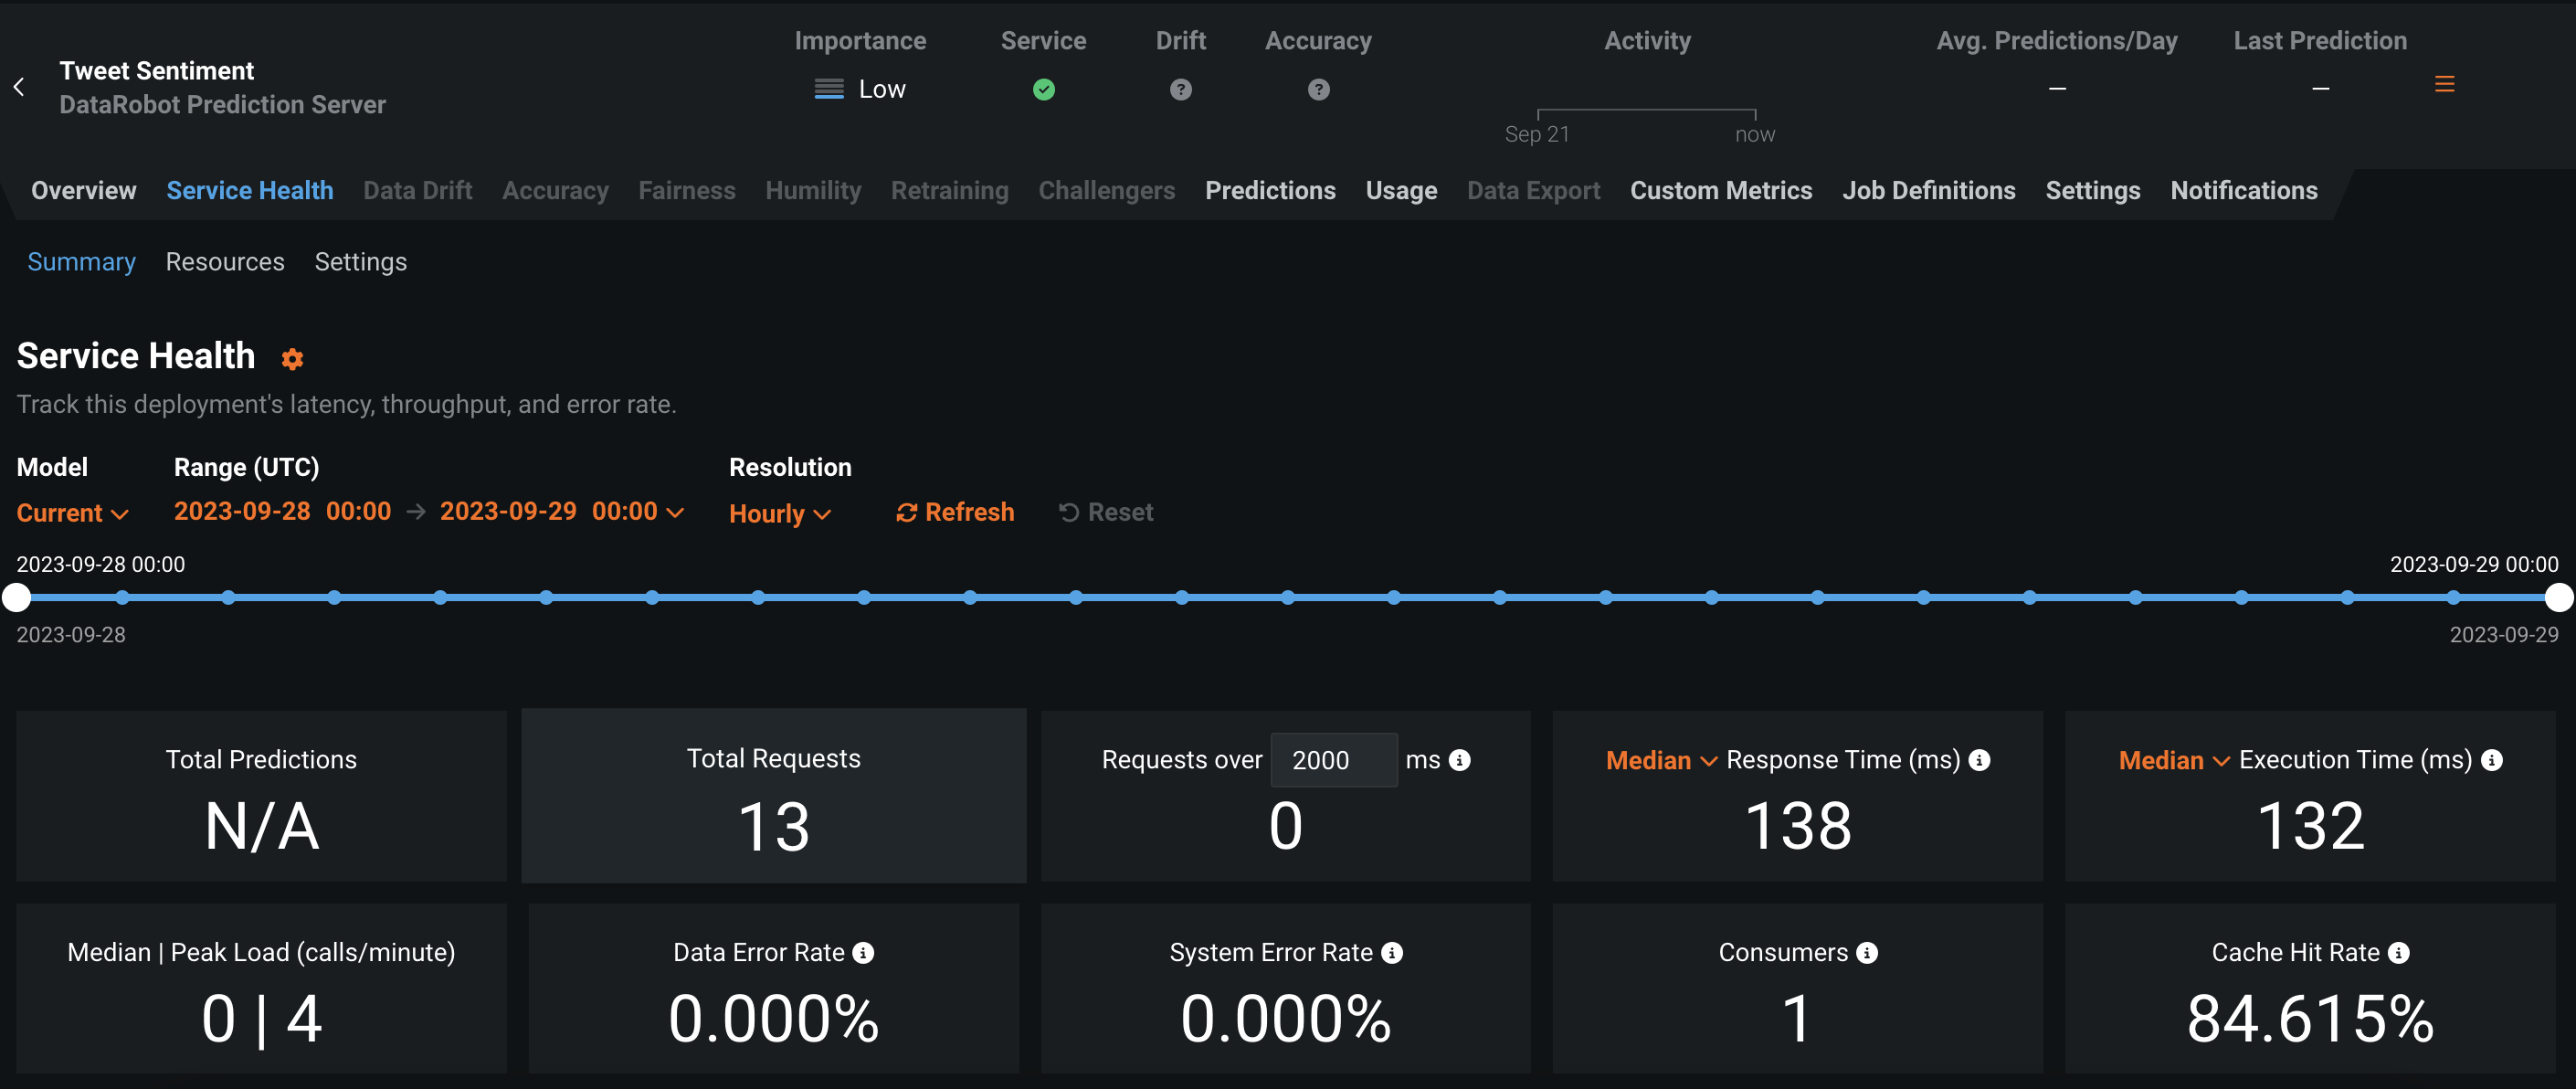

If the decision model deployment is created in another object or is pre-existing, use the below code to create the reference object.

In [ ]:
"""import datarobotx as drx
deployment_sentiment = drx.Deployment.from_url('https://app.datarobot.com/deployments/650d83638861bb1d3ffddb27')
deployment_sentiment"""

"import datarobotx as drx\ndeployment_sentiment = drx.Deployment.from_url('https://app.datarobot.com/deployments/650d83638861bb1d3ffddb27')\ndeployment_sentiment"

## Generative AI model
Next, build the Generative AI model that takes user tweets as a prompt and a filtered set of conversations from the vector database to craft a reply to the user tweet.

In [ ]:
import os

OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]
OPENAI_ORGANIZATION = os.environ["OPENAI_ORGANIZATION"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_DEPLOYMENT_NAME = os.environ["OPENAI_DEPLOYMENT_NAME"]


def load_model(input_dir):
    """Custom model hook for loading our knowledge base."""
    import os

    from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
    from langchain.vectorstores.faiss import FAISS

    os.environ["OPENAI_API_TYPE"] = OPENAI_API_TYPE
    os.environ["OPENAI_API_BASE"] = OPENAI_API_BASE
    embedding_function = SentenceTransformerEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        cache_folder=input_dir + "/" + "storage/deploy/sentencetransformers",
    )
    db = FAISS.load_local(input_dir + "/" + "storage/deploy/faiss-db", embedding_function)
    return OPENAI_DEPLOYMENT_NAME, db


def score_unstructured(model, data, query, **kwargs) -> str:
    """Custom model hook for making completions with our knowledge base."""
    import json

    from langchain.chains import ConversationalRetrievalChain
    from langchain.chat_models import AzureChatOpenAI
    from langchain.vectorstores.base import VectorStoreRetriever

    try:
        deployment_name, db = model
        data_dict = json.loads(data)
        llm = AzureChatOpenAI(
            deployment_name=OPENAI_DEPLOYMENT_NAME,
            openai_api_type=OPENAI_API_TYPE,
            openai_api_base=OPENAI_API_BASE,
            openai_api_version=OPENAI_API_VERSION,
            openai_api_key=data_dict["openai_api_key"],
            openai_organization=OPENAI_ORGANIZATION,
            model_name=OPENAI_DEPLOYMENT_NAME,
            temperature=0,
            verbose=True,
        )
        retriever = VectorStoreRetriever(vectorstore=db)
        chain = ConversationalRetrievalChain.from_llm(
            llm, retriever=retriever, return_source_documents=True
        )
        if "chat_history" in data_dict:
            chat_history = [
                (
                    human,
                    ai,
                )
                for human, ai in data_dict["chat_history"]
            ]
        else:
            chat_history = []
        rv = chain(
            inputs={
                "question": data_dict["question"],
                "chat_history": chat_history,
            },
        )
        rv["references"] = [doc.metadata["source"] for doc in rv.pop("source_documents")]
    except Exception as e:
        rv = {"error": f"{e.__class__.__name__}: {str(e)}"}
    return json.dumps(rv)

## Synthesis

Now that you have both the models hosted and ready, you can run our solution. The `get_completion` function ingests a user support tweet, uses the huggingface model to check sentiment strength and then decides to send the tweet either to the Generative AI Model or a human support person.

In [ ]:
import json
import warnings

from json2html import *

warnings.filterwarnings("ignore")


def get_completion(question):
    predict_sentiment = deployment_sentiment.predict_unstructured({"tweet": question})
    sentiment = predict_sentiment["label"]
    score = predict_sentiment["score"]
    if (sentiment == "negative") & (score > 0.8):
        output_cleaned = {
            "question": question,
            "sentiment": sentiment,
            "score": round(score, 2),
            "route": "L1 support person",
            "answer": "We are so sorry for your experience. Please dm us the \
                          details and our staff will get in touch with you!",
        }
    else:
        output = score_unstructured(
            load_model("."),
            json.dumps(
                {
                    "question": "You are support agent managing a company's twitter account. \
                 Craft a reply following customer tweet. Add quick troubleshooting \
                 steps from reference tweets in the reply if relevant. Only use \
                 information from provided documents."
                    + question,
                    "openai_api_key": os.environ["OPENAI_API_KEY"],
                }
            ),
            None,
        )
        output = json.loads(output)
        output_cleaned = {
            "question": question,
            "sentiment": sentiment,
            "score": round(score, 2),
            "route": "Generative AI",
            "answer": " ".join([i for i in output["answer"].split(" ") if i.find("@") == -1]),
            "references": [
                (open(file, "r")).read()[0:300].replace("\t", " ").replace("\n", " ") + "...."
                for file in output["references"]
            ],
        }
    html_ = json2html.convert(json=output_cleaned)
    return html_

## Outcome

View some examples in action below.

In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore their products are awesome, but pricey!!!"
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,"@AwesomeStore their products are awesome, but pricey!!!"
sentiment,positive
score,0.97
route,Generative AI
answer,"Thank you for your feedback! We appreciate your support. If you have any questions or need assistance with our products, feel free to reach out to our TS team at https://t.co/wv43hRjDLY. They will be happy to provide you with more information."
references,"@411026 For more information contact our TS team: https://t.co/wv43hRjDLY @AskAwesomeStore where are the proper specs of these drives @AskAwesomeStore why does this info even exist https://t.co/ebvtJgDRcY @411026 Here is some information about our AwesomeStore Expansion Desktop family of drives: ....@697662 We apologize for the problems you experienced in contacting us. We notice you were able to create an email support case (09008287). A technician will be responding to you soon regarding your concerns expressed there. @AskAwesomeStore Worst support site ever. Hard to get to any contact form....@620716 Please send us a private message on Twitter with the information we requested. @AskAwesomeStore To which address I need to send? @620716 Please send us a PM with your full name, email address, the serial number of your drive, and some information about the place of purchase. Hi @AskAwesom....@620718 How can we help you today? Please send us a PM with the serial number of your drive. Does the light come on? Does the drive make any noise? @AskAwesomeStore Are you still giving support through Twitter?...."


In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore I recently bought a hard disk and my laptop doesnt recognize it."
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,@AwesomeStore I recently bought a hard disk and my laptop doesnt recognize it.
sentiment,negative
score,0.78
route,Generative AI
answer,"Hi sorry to hear that you're having trouble with your hard disk. Let's try some troubleshooting steps to see if we can resolve the issue. First, please make sure that the hard disk is properly connected to your laptop. Check if the light on the hard disk is on and if it's making any noise. If not, please send us a PM with the serial number of your drive so we can assist you further."
references,"@620718 How can we help you today? Please send us a PM with the serial number of your drive. Does the light come on? Does the drive make any noise? @AskAwesomeStore Are you still giving support through Twitter?....@411026 For more information contact our TS team: https://t.co/wv43hRjDLY @AskAwesomeStore where are the proper specs of these drives @AskAwesomeStore why does this info even exist https://t.co/ebvtJgDRcY @411026 Here is some information about our AwesomeStore Expansion Desktop family of drives: ....@620716 Please send us a private message on Twitter with the information we requested. @AskAwesomeStore To which address I need to send? @620716 Please send us a PM with your full name, email address, the serial number of your drive, and some information about the place of purchase. Hi @AskAwesom....@681613 What specific problem are you experiencing with your AwesomeStore drive? What country do you reside? What is the drive serial number? Please DM this to us. We are following. @AskAwesomeStore Good day!2 years ago I purchased hard disk your company, at this point, I have a problem with him. T...."


In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore What are these nbi files on my drive. Can I delete them?"
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,@AwesomeStore What are these nbi files on my drive. Can I delete them?
sentiment,negative
score,0.53
route,Generative AI
answer,"The .nbi files are part of our backup system and are needed for data restores. It is not recommended to delete them. If you have any concerns or need further assistance, please contact our regional Technical Support team for guidance. They will be able to provide you with the necessary help. Thank you!"
references,"@119615 Unfortunately, the .nbi files cannot be deleted. Please contact your regional Technical Support team for assistance: https://t.co/P1923ANV5x @AskAwesomeStore Who is that? @AskAwesomeStore @119616 I have 3.43GB of NBI files. Can I delete all but the newest? I did not see the earlier thread....@697661 We notice that you have created a support case already regarding this problem &amp; a technician will contact you soon. NBI files are associated with our Dashboard program. BMI files are not associated with our software at all, so we could not make any recommendation on those @AskAwesomeSto....@620721 Can you please DM a screenshot of these files? Any recent changes to the drive or computer? Were these files manually added to drive? @AskAwesomeStore Oh Its just a damn HERMES ransomeware nvm thank you @AskAwesomeStore I formatted it. @AskAwesomeStore All of my files are suddenly turned....@746736 We're sorry about the issue you are having with your drive. Based on the information you have provided, we would recommend that you contact your regional Technical Support during their regular office hours: https://t.co/FsYygcod7H We appreciate your patience. @AskAwesomeStore Hi have 63000...."


In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore There is noise coming from my hdd. what should i do?"
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,@AwesomeStore There is noise coming from my hdd. what should i do?
sentiment,negative
score,0.71
route,Generative AI
answer,"I'm sorry to hear about the noise coming from your HDD. To better assist you, could you please provide us with the model name of your AwesomeStore drive? Additionally, have you tried using the drive on a different port, cable, or computer to see if the issue persists? If not, please give that a try. If the noise continues and the drive is not being recognized in the device manager, it may indicate a hardware issue. In that case, I recommend reaching out to our regional Technical Support team for further assistance. They will be able to help you troubleshoot and determine the best course of action."
references,"@620718 How can we help you today? Please send us a PM with the serial number of your drive. Does the light come on? Does the drive make any noise? @AskAwesomeStore Are you still giving support through Twitter?....@569196 Let's see how we can help. Please send us a PM with the serial number of your drive. Does the light come on? Does the drive make any noise? @AskAwesomeStore I don't the pm and series number the light comes and makes a very low noise @569196 What kind of noise is the drive making specifica....@640300 https://t.co/SNIV4Oqf00 @AskAwesomeStore i have purchased AwesomeStore harddisk from amazon on 23rd sep 2016. now my hdd has some technical issues for which i submit this to your service centre in ambala haryana india named Aggarwal IT Solutions. but my problem is not being sought out. very....@540250 Let's see what we can do. Please send us a PM with the serial number of your drive. Does the light come on? Does the drive make any noise? @AskAwesomeStore Hey, I have a new backup plus slim for windows. having trouble. can you help?...."


In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore Your products break in the first month. And your refund policy sucks!!"
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,@AwesomeStore Your products break in the first month. And your refund policy sucks!!
sentiment,negative
score,0.96
route,L1 support person
answer,We are so sorry for your experience. Please dm us the details and our staff will get in touch with you!


In [ ]:
from IPython.core.display import display, HTML

question = "@AwesomeStore I ordered a drive off of ebay and it turned out to be fake!! \
Never buying their products everrrr"
display(HTML(get_completion(question)))

# Making predictions
  - Making predictions with deployment [Tweet
    Sentiment](https://app.datarobot.com/deployments/65158e53ebe4c4b231fddcbb/overview)
# Predictions complete


question,@AwesomeStore I ordered a drive off of ebay and it turned out to be fake!! Never buying their products everrrr
sentiment,negative
score,0.93
route,L1 support person
answer,We are so sorry for your experience. Please dm us the details and our staff will get in touch with you!


## Integration into X (Twitter)
Once your Generative AI deployment is ready, you can use it in an X Bot via the library <a href='https://www.tweepy.org/'>Tweepy</a>. Inorder to create the bot, you will need to build a bot service that listens to mentions perodically, and the X developer API provides the <a href='https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/api-reference/get-users-id-mentions'>endpoint</a> to get mentions. Steps to create an X bot with python are illustrated <a href='https://realpython.com/twitter-bot-python-tweepy/'>here</a>.

## Conclusion

This accelerator outlined how to:

<br> - Generate conversations as documents from tweets to load into vector databases
<br> - Deploy external model from HuggingFace in DataRobot platform
<br> - Use Retrieval Augmented Generation with a generative AI model
<br> - Use predictive models along with henerative AI models to automate support workflows
<br> in order to optimize customer support workflows